In [285]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [286]:
def f(x):
    return 3*x**2 - 4*x + 5

In [287]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [288]:
h =0.001
x =2/3
(f(x + h) - f(x))/h

0.0029999999995311555

In [289]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [290]:
h = 0.0001
d1 = a*b + c
c += h
d2 = a*b + c
print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'Slope: {(d2 - d1)/h}')

d1: 4.0
d2: 4.0001
Slope: 0.9999999999976694


In [291]:
class Value:  # Takes single scalar value that it wraps and keep track of 
    # _children is a tuple that stores the variables used in the operation. when values are created from constructor, _children is empty
    # _op stores the operation 
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self): # Python default. Returns the string and provides a better representation of the output
        return f"Value(data={self.data})"
    
    # creating a value through the operations saves the children from the operation
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad     # += accumulates the gradients instead of = that overwrites previous grads. Same for all other _backward()
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__ (self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward        
        return out

    def __rmul__(self, other): # automatically checks and corrects relexive property
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):  # 
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        


In [292]:
# from Kaparthy github
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [293]:
# Visualizing the expression graph
from graphviz import Digraph

def trace(root):
    # build set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            # print(v)
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # print from left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create rectangular node for it
        dot.node(name=uid, label = '{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if not part of an operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot



# Neural Network

In [294]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

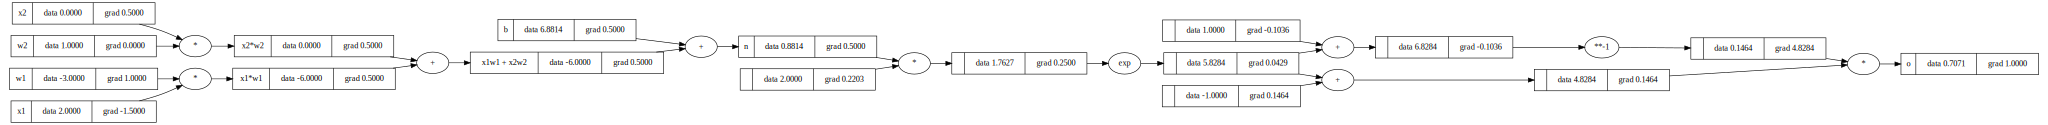

In [295]:
draw_dot(o)

# Implementing with Pytorch

In [296]:
import torch
import random

In [297]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Neural Network

In [298]:
class Neuron:
    def __init__(self, nin): # number of inputs into a neuron
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] # create a weight for the neuron
        self.b = Value(random.uniform(-1, 1)) # create a bias
    
    def __call__(self, x):
        # w.x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # Prevent from always returning a list
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [299]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # 3 neurons in inp layer, 4 in both hidden, 1 neuron in output layer
n(x) 

Value(data=0.15143838545070284)

In [300]:
len(n.parameters())

41

In [301]:
# Consider a dataset
xs = [
    [2.0, 3.9, -1.0],    
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

Loss: Measures how well the NN performs

In [332]:
for k in range(20):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # MSE

    # Zero grad to flush accumulated grads to 0
    for p in n.parameters():
        p.grad = 0.0

    # Backward Pass
    loss.backward()

    # Update through gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.001124035907898641
1 0.0011219800072460458
2 0.001119931582391636
3 0.0011178905927410477
4 0.0011158569979927422
5 0.0011138307581353923
6 0.001111811833445277
7 0.0011098001844837009
8 0.0011077957720944489
9 0.0011057985574012593
10 0.001103808501805365
11 0.0011018255669829427
12 0.0010998497148827734
13 0.0010978809077237604
14 0.0010959191079925373
15 0.0010939642784411668
16 0.0010920163820847242
17 0.0010900753821990218
18 0.0010881412423183186
19 0.0010862139262330566


In [318]:
ypred

[Value(data=0.9873244642149369),
 Value(data=-0.9784019277021807),
 Value(data=-0.9709488185215477),
 Value(data=0.9739705373295371)]